<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/main_for_standardVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install POT

In [27]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "vae_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vae_models.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
vae_models.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.


In [28]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import vae_models
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from vae_models import standVAE
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.23 GB


In [29]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data(file_names, num_points=num_points, device=device)
print(len(data_loader))
# VAEモデル構築
vae = standVAE(n_in_out=3 * num_points, n_z=3).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-5)

9


In [30]:
epochs=5000
interval=100

rec_error_record = []
reg_error_record = []
total_error_record = []
z_list = []
for i in range(epochs):
    vae.train()
    loss_rec = 0
    loss_reg = 0
    loss_total = 0


    for k, (x,) in enumerate(data_loader):
            # xをdeviceに移動
            x = x.to(device)
            x = x.squeeze(0)

            # VAEの出力と損失を計算
            y, z, mu, logvar = vae(x)  #
            lrec, lreg = vae.loss(y, x, mu, logvar)

            # 損失の合計を計算
            loss = lrec + lreg
            loss_rec += lrec.item()
            loss_reg += lreg.item()
            loss_total += loss.item()

            # 最適化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 最終エポックでzを収集
            if i == epochs - 1:
                z_list.append(z.cpu().detach().numpy())

    # 平均を計算
    loss_rec /=  (k + 1)
    loss_reg /=  (k + 1)
    loss_total /=  (k + 1)

    # ログの記録
    rec_error_record.append(loss_rec)
    reg_error_record.append(loss_reg)
    total_error_record.append(loss_total)

    # 指定間隔でのログ出力
    if i % interval == 0:
        print(f"Epoch:{i} Loss_Rec:{loss_rec} Loss_Reg:{loss_reg} Loss_Total:{loss_total}")

# 最終エポック後に z_list を保存
if len(z_list) > 0:
    z_array = np.array(z_list)
    np.save("z_list_final.npy", z_array)
    print(f"z_list saved with shape: {z_array.shape}")
else:
    print("Warning: z_list is empty. Nothing was saved.")

Epoch:0 Loss_Rec:5807.753200954861 Loss_Reg:0.02649377452002631 Loss_Total:5807.779730902777
Epoch:100 Loss_Rec:1142.9906480577256 Loss_Reg:28.784327612982857 Loss_Total:1171.7749905056423
Epoch:200 Loss_Rec:1142.810106065538 Loss_Reg:14.145392100016275 Loss_Total:1156.9555053710938
Epoch:300 Loss_Rec:1141.5501844618057 Loss_Reg:9.421170658535427 Loss_Total:1150.9713745117188
Epoch:400 Loss_Rec:1140.9667833116318 Loss_Reg:7.425015449523926 Loss_Total:1148.3917914496528
Epoch:500 Loss_Rec:1143.2030436197917 Loss_Reg:6.476622369554308 Loss_Total:1149.679680718316
Epoch:600 Loss_Rec:1139.9719102647568 Loss_Reg:6.040492746565077 Loss_Total:1146.0124104817708
Epoch:700 Loss_Rec:1142.9318712022568 Loss_Reg:5.582718425326878 Loss_Total:1148.5145670572917
Epoch:800 Loss_Rec:1141.9521077473958 Loss_Reg:5.53789488474528 Loss_Total:1147.489983452691
Epoch:900 Loss_Rec:1142.0304226345486 Loss_Reg:5.215493732028538 Loss_Total:1147.2459309895833
Epoch:1000 Loss_Rec:1141.0294257269966 Loss_Reg:4.9466

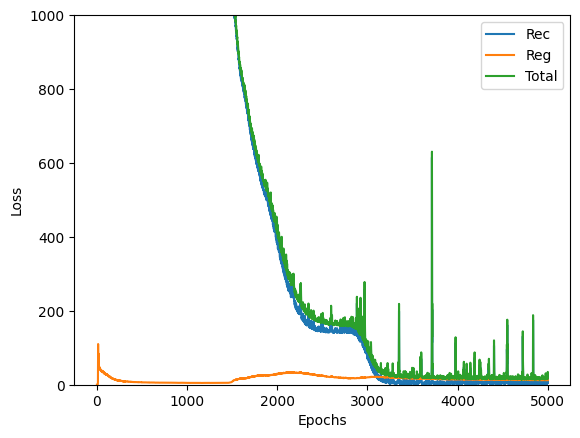

Model weights have been saved!


In [31]:
# 損失の可視化
visualize_loss(rec_error_record, reg_error_record, total_error_record)

# モデル保存
torch.save(vae.state_dict(), '/content/drive/MyDrive/chair/StandVAE_Np5000_MSE_0216.pth')
print("Model weights have been saved!")

In [32]:
print(z_list) # z mu logvar

[array([[2.354351 , 0.4440547, 2.045235 ]], dtype=float32), array([[ 2.2926066, -2.0420706,  1.056101 ]], dtype=float32), array([[ 0.34012753, -3.045607  , -1.0175772 ]], dtype=float32), array([[-1.8404964, -1.1817333, -2.1515262]], dtype=float32), array([[ 1.4406486 , -3.1297681 ,  0.40061608]], dtype=float32), array([[1.3774865, 1.9011836, 2.082407 ]], dtype=float32), array([[-0.7416199, -2.6498785, -1.5819916]], dtype=float32), array([[ 2.3747516, -0.8785953,  1.6512419]], dtype=float32), array([[-2.6007774 ,  0.34847236, -2.0687141 ]], dtype=float32)]


# 再構成形状の可視化

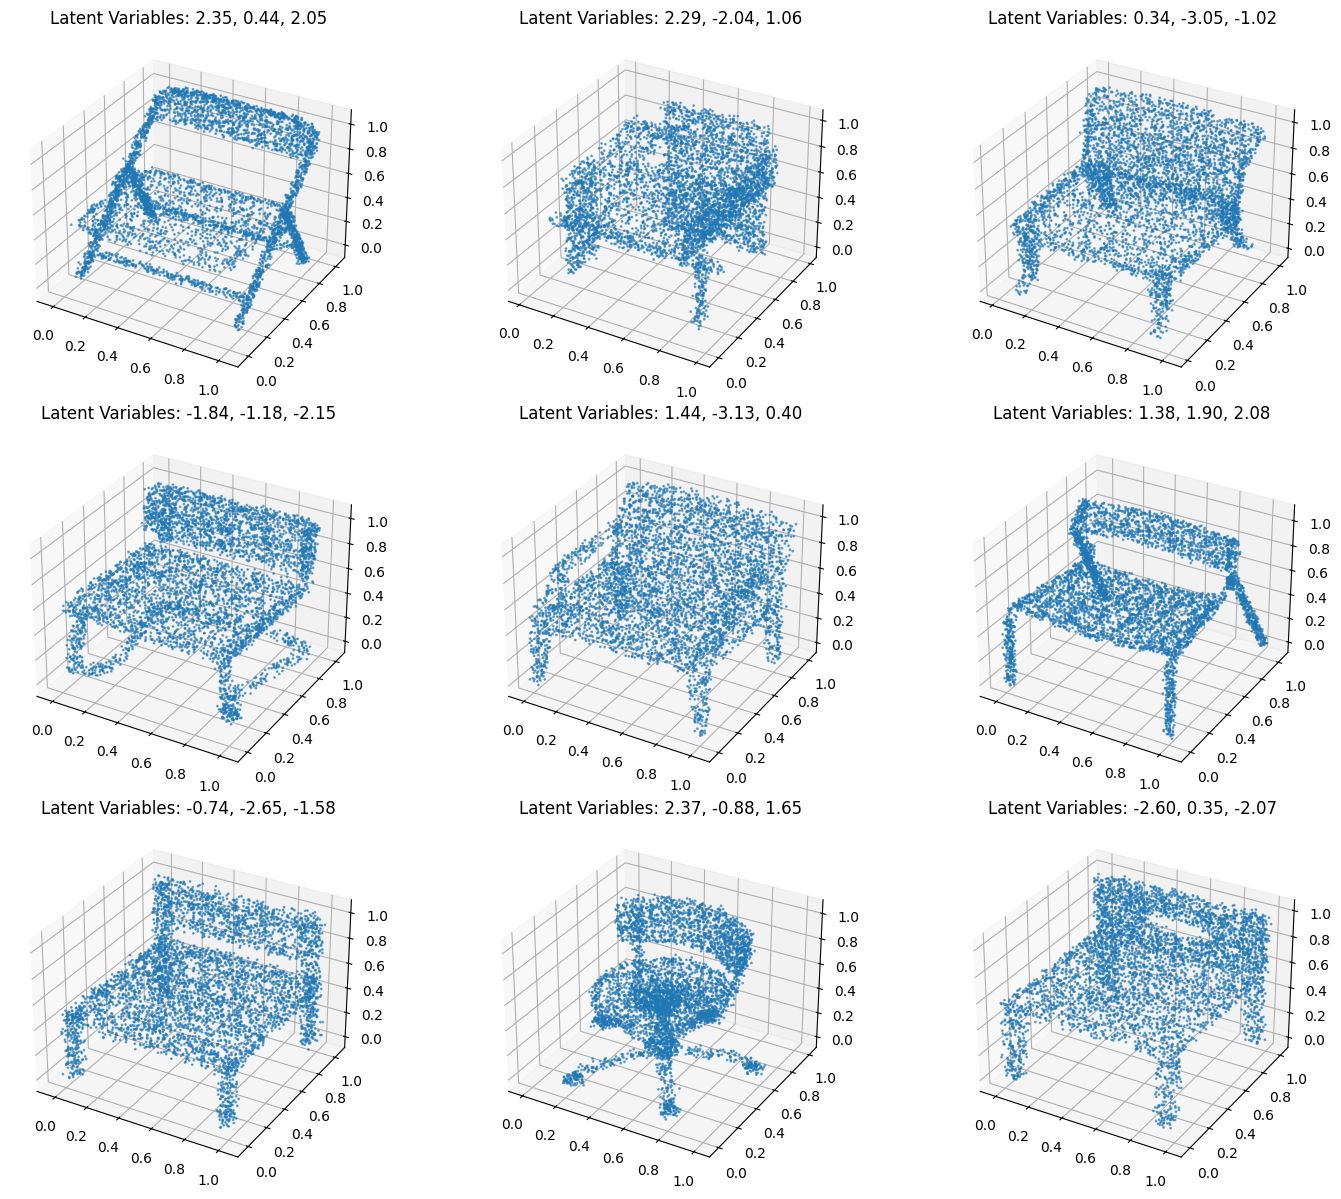

In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    recon_batch = vae.decode(z)  # z をバッチの形状に変換

    # CPU上で detach して numpy に変換
    reconst = recon_batch.cpu().detach().numpy().reshape(-1)

    # num_points に基づいて点群を分割
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# 再構成誤差チェック using CD

Chamfer Distances: [0.18856392800807953, 0.12280239164829254, 0.15161676704883575, 0.14002326130867004, 0.15489795804023743, 0.2037409543991089, 0.1748780906200409, 0.1270599663257599, 0.1567906141281128]
Average Chamfer Distance: 0.15781932572523752


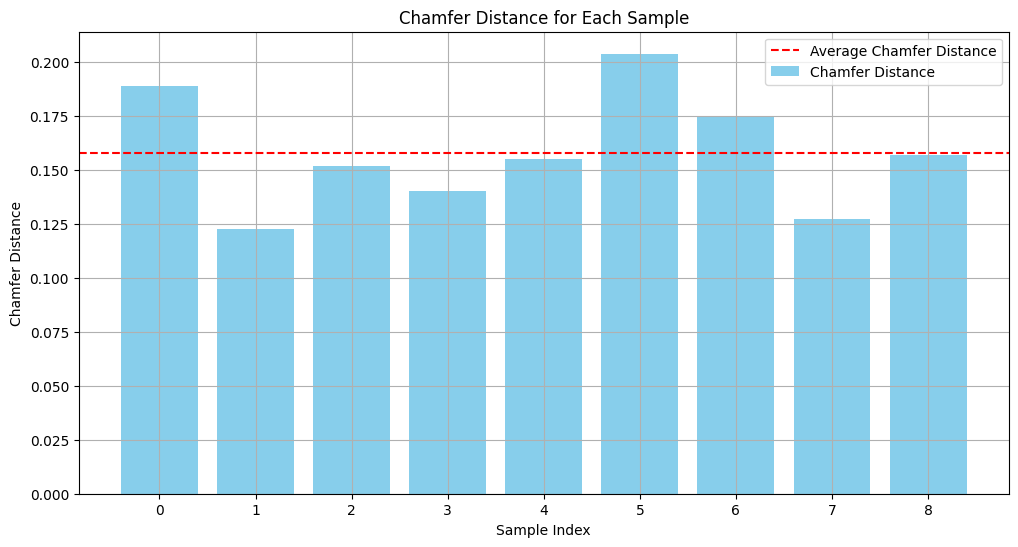

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

tensor([[2.3544, 0.4441, 2.0452]], device='cuda:0')
tensor([[ 2.2926, -2.0421,  1.0561]], device='cuda:0')
tensor([[ 0.3401, -3.0456, -1.0176]], device='cuda:0')
tensor([[-1.8405, -1.1817, -2.1515]], device='cuda:0')
tensor([[ 1.4406, -3.1298,  0.4006]], device='cuda:0')
tensor([[1.3775, 1.9012, 2.0824]], device='cuda:0')
tensor([[-0.7416, -2.6499, -1.5820]], device='cuda:0')
tensor([[ 2.3748, -0.8786,  1.6512]], device='cuda:0')
tensor([[-2.6008,  0.3485, -2.0687]], device='cuda:0')
EMD Distances: [0.21948501500903564, 0.14614608178035113, 0.1854052272294953, 0.1869715302042647, 0.1889254559011399, 0.22175585126660102, 0.2087155705332661, 0.14837633321761776, 0.22225634085992046]
Average EMD Distance: 0.19200415622241027


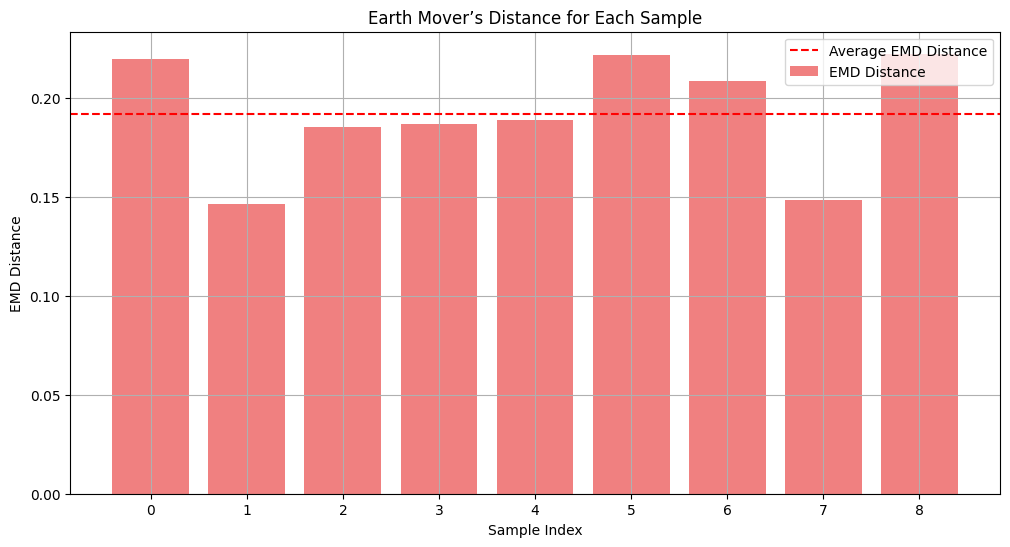

In [35]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    print(z_list[i])
    recon_batch = vae.decode(z_list[i])

    # 再構築された点群の形状を整える
    reconst = recon_batch.cpu().detach().reshape(-1)
    reconst_x = reconst[:num_points]
    reconst_y = reconst[num_points:2*num_points]
    reconst_z = reconst[2*num_points:3*num_points]
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).to(device)

    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
